# NTDS assignment 2: network models
[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), *PhD student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

For this assignment we will work on a network representing the collaboration between scientists in the field of General Relativity and Quantum Cosmology. The network comes from [SNAP](http://snap.stanford.edu/data/ca-GrQc.html) and is described as follows:

> Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print [arXiv](https://arxiv.org) and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author *i* co-authored a paper with author *j*, the graph contains a undirected edge from *i* to *j*. If the paper is co-authored by *k* authors this generates a completely connected (sub)graph on *k* nodes. The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv.

In [1]:
%matplotlib inline

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
G = nx.read_edgelist(os.path.join('..', 'data', 'arxiv_collaboration_network.txt'))

In [3]:
print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

My network has 5242 nodes.
My network has 14496 edges.


## 1. Comparing to model networks

1.1 In this part of the assignment, you have to create an Erdős–Rényi and Barabási-Albert graph using NetworkX, and compare them to the collaboration network. Try to simulate the original network as best as you can. When choosing parameters for the networks, take into account the number of vertices and edges of the original network. The number of vertices should be exactly the same. Comment on your choice of parameters.

In [23]:
# some usefull quantities
n_nodes = len(G.nodes())
n_links = G.size()
n_links_max =  (n_nodes * (n_nodes - 1)) /2 

# ER network :
p_er = n_links / n_links_max # this is the probality of connection

er = nx.erdos_renyi_graph(n_nodes, p_er)

# BA network :
ba_node_attached = int(np.ceil( n_links/n_nodes)) # mean number of nodes
ba = nx.barabasi_albert_graph(n_nodes,ba_node_attached)

As we see in the next box, er and ba networks have very similar number of links. This is quite normal because we gabe to ER the exact probability to create such a number of links. For BA it is more difficult as we have to furnish the algorithm with an integer value (the numer of edges to attach a new node = 1/2 of the average degree)


In [6]:
print('My Original network has {} nodes.'.format(len(G.nodes())))
print('My Original network has {} edges.'.format(G.size()))
print('--------------------------------------')
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('--------------------------------------')
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))


My Original network has 5242 nodes.
My Original network has 14496 edges.
--------------------------------------
My Erdős–Rényi network has 5242 nodes.
My Erdős–Rényi network has 14651 edges.
--------------------------------------
My Barabási-Albert network has 5242 nodes.
My Barabási-Albert network has 15717 edges.


1.2 Check the size of the largest connected component in each graph and compare them to the original network. In the Erdős–Rényi model, what should the probability of creating each edge be in order to have the same expected size of the largest component? Justify. Generate a graph with this parameter to check if you indeed get a similar value.

In [7]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_G.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

4158
5217
5242


As we see the size of the largest component is much smaller in reality than in the ER and BA models. Nest we are going to compute the parameter p of the ER model in order to have the same expected size of the giant component. For this we use a formulation found in the slides, that allows us to express the value of p in function of u. 

In [13]:
u_giant = (1 - len(giant_G.nodes())/n_nodes) # Proportions of nodes that are not in the giant component 
p_giant = (np.power(u_giant,1/(n_nodes-1)) - 1)/(u_giant-1) # expresiion linking p to u.  

print('The parameter p for an Erdős–Rényi network with the same expected size of the giant component is {}.'.format(p_giant))

er_giant =  max(nx.connected_component_subgraphs(nx.erdos_renyi_graph(n_nodes, p_giant)), key=len)

print('The size of the component in a randomly generated network with this parameter is {}.'.format(len(er_giant.nodes())))

The parameter p for an Erdős–Rényi network with the same expected size of the giant component is 0.00037905457554677585.
The size of the component in a randomly generated network with this parameter is 4146.


1.3 Look at the clustering coefficient of the original network. Is there a network model we talked about that could have a clustering coefficient that is close? Explain.

In [ ]:
nx.average_clustering(G)

The average clustring coefficient is close to 1/2. The network that could have the type of coefficient is the BA Model. The ER model can't have a coefficient this high with the number of nodes we have.

## 2. Creating a network with a predefined degree distribution

In this part of the assignment, you will have to create a random network from a predefined degree distribution. There are several network models which can create a random network with the exact same degree distribution as the original, or with the same expected distribution as the original. Refer to section 4.8 of [the Barabási book](http://networksciencebook.com) for more information.

One of the most famous ones is the configuration model. The model for a graph with $L$ edges in total is constructed in the following steps:

- Assign a degree to each node, represented as stubs (half-links). The degree sequence is either generated analytically from a preselected distribution, or it is extracted from the adjacency matrix of a real network. Note that we must start from an even number of stubs to avoid being left with unpaired stubs.
- Randomly select a stub pair and connect them. Then randomly choose another pair from the remaining $2L - 2$ stubs and connect them. This procedure is repeated until all stubs are paired up.

*Reminder:* A stub is a half-link, representing the half of an edge. It contains one node and can be paired up with another stub to create an edge (between the two corresponding nodes).

2.1 However, this model allows for the creation of multi-links (multiple edges between the same pair of vertices) and self-loops, thus leading to a non-simple graph. In this assignment, you will implement a greedy configuration model, to avoid these problems.

The algorithm goes as follows:
- Extract the degree sequence from our collaboration network.
- Assign a target degree to each node, represented as stubs or half-links. Use the degree sequence extracted from the collaboration network.
- Sort the nodes by degree. 
    - Pick the node with the highest target degree. Delete all its stubs from the list of stubs to make sure we don't create a self loop.
    - Until all its weighted degree equals its target degree: 
        - Randomly select one stub from the list of stubs (corresponding to one of the other nodes), and connect these two nodes. In case the two chosen nodes are already connected, simply increase the weight of this edge by one. Be careful to randomly select from stubs and not from nodes, as this means the chances of selecting a node will be proportional to its target degree.
    - When the number of edges adjacent to this node corresponds to its target degree, go on to the second node in the list. 
    - Repeate this procedure until all stubs are paired up, or there is only one node left with a pair number of stubs. In that case, don't create a self-loop, but discard the stubs.
    
*Hints*: 
 - Use `nx.empty_graph()` to create an empty graph.
 - Use `G.add_edge(node1,node2,weight = 1)` to add an edge to a weighted graph.
 - Use `G.edge[node1][node2]['weight'] += 1` to increment the weight of an edge by one.

In [118]:
def greedy_configuration(degree_distribution):
    G = nx.empty_graph()
    stubs = [i for i in range(len(degree_distribution)) for n in range(degree_distribution[i])]

    for i in range(len(degree_distribution)):
        # removing actual stubs from i to avoid self loops :
        stubs_available = 0
        while stubs[0] == i :
            stubs_available += 1
            stubs.remove(i)

        # random choice in all the stubs
        for n in range(stubs_available):
           
            j = random.choice(stubs)
            if G.has_edge(i,j):
                G.edges[i,j]['weight'] += 1
            else :
                G.add_edge(i,j,weight = 1)
                
            stubs.remove(j)
            if stubs == [] :
                return G
        

In [119]:
degree_distribution=sorted(dict(nx.degree(G)).values(),reverse=True) # degree distribution sorted from highest to lowest
gc = greedy_configuration(degree_distribution)

2.2 Verify that the networks have the same number of nodes. Plot the difference between the weighted degree distributions to verify that they are identical. If not, why?

Number of Nodes : Original = 5244 - Generated = 5244
Same degree distribution : True


Text(0.5,1,'Plot of the Generated Distribution refered to the Original')

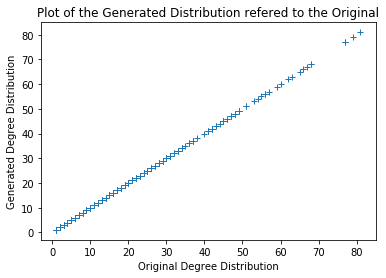

In [133]:
degree_sequence_gc=sorted(dict(nx.degree(gc, weight = 'weight')).values(),reverse=True) #weighted degree distribution

# let us verify that the node number and degree sequence is the same for our generated network
print('Number of Nodes : Original = ' + str(len(G.nodes)) + ' - Generated = ' + str(len(gc.nodes)))
print('Same degree distribution : ' + str(degree_sequence_gc == degree_distribution))
plt.plot(degree_distribution,degree_sequence_gc,'+')
plt.xlabel('Original Degree Distribution')
plt.ylabel('Generated Degree Distribution')
plt.title('Plot of the Generated Distribution refered to the Original')

As we see the number of nodes and the degree distribution are perfectily identical. It is possible that they are not identical if there was some self-loops. We we always took stubs by pairs so we are neer in this case. 

2.3 Should these two networks have the same adjacency matrices? Justify.

They shouldn't have the same adjacency matrix because the links were randomly chosen. The same degree distribution doesn't mean that a node whith a certain number of connection is always conneted to nodes having the same degrees : this choice was random. 

2.4 Draw both the generated and original networks. Are they similar? If not, why? Try to explain.

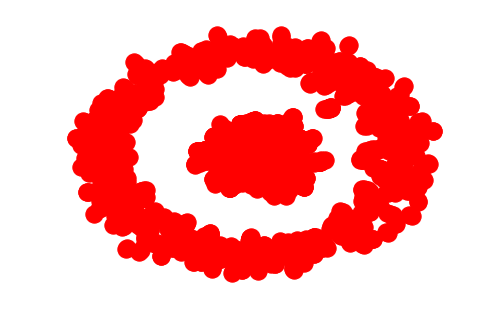

In [142]:
nx.draw(G)

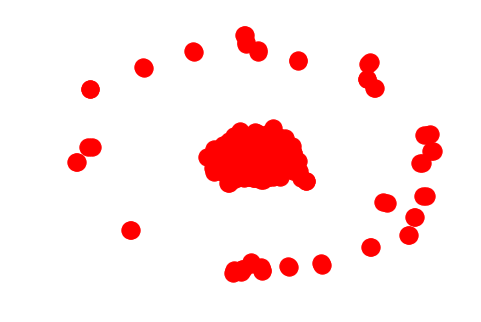

In [143]:
nx.draw(gc)

They have the same global shape but there have a lot of differences. The central nodes are the ones the one having the highest degrees. We see that this kernel in much more dense in our generated model. The *outside ring* in our generated grah is much *thinner* : this means that nodes with small degree are more connected in the original graph.

2.5 Do you expect the properties studied in the first part of the assignment to be close to the original graph? Justify.

In [153]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_gc =  max(nx.connected_component_subgraphs(gc), key=len)

print('The size of the original giant component {} on a total of {}. ' .format(len(giant_G.nodes()) ,len(G.nodes())))
print('The size of the generated giant component {} on a total of {}.'.format(len(giant_gc.nodes()),len(gc.nodes()) ))



The size of the original giant component 4158 on a total of 5244. 
The size of the generated giant component 5186 on a total of 5244.


As we see the giant component is not correct in our generated graph. This is quite normal to have different sizes because it was grown by taking first the high degree nodes, resulting a very concentrated network. 